In [23]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 🔧 Display settings
pd.set_option('display.max_columns', None)

# 📥 Load IPL data
ipl_matches = pd.read_csv("ipl/matches.csv")
ipl_deliveries = pd.read_csv("ipl/deliveries.csv")

print("IPL Matches shape:", ipl_matches.shape)
print("IPL Deliveries shape:", ipl_deliveries.shape)
ipl_matches.head()


IPL Matches shape: (1095, 20)
IPL Deliveries shape: (260920, 17)


,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [24]:
# Drop missing winners
ipl_matches = ipl_matches.dropna(subset=['winner'])
ipl_matches = ipl_matches[ipl_matches['winner'].isin(ipl_matches['team1'].unique())]

# Binary label
ipl_matches['team1_win'] = (ipl_matches['winner'] == ipl_matches['team1']).astype(int)

# Head-to-head win rate
h2h = (
    ipl_matches.groupby(['team1', 'team2'])['team1_win']
    .mean().reset_index().rename(columns={'team1_win': 't1_h2h_win_rate'})
)
ipl_matches = ipl_matches.merge(h2h, on=['team1', 'team2'], how='left')

# Toss win advantage
ipl_matches['toss_win_match_win'] = (ipl_matches['toss_winner'] == ipl_matches['winner']).astype(int)
toss_adv = (
    ipl_matches.groupby('team1')['toss_win_match_win']
    .mean().reset_index().rename(columns={'toss_win_match_win': 't1_toss_advantage'})
)
ipl_matches = ipl_matches.merge(toss_adv, on='team1', how='left')

# Venue win rate
venue_win = (
    ipl_matches.groupby(['venue', 'team1'])['team1_win']
    .mean().reset_index().rename(columns={'team1_win': 't1_venue_win_rate'})
)
ipl_matches = ipl_matches.merge(venue_win, on=['venue', 'team1'], how='left')


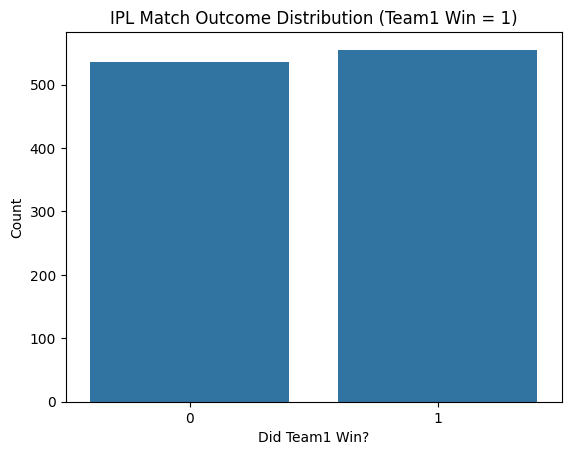

In [25]:
# Class balance
sns.countplot(x='team1_win', data=ipl_matches)
plt.title("IPL Match Outcome Distribution (Team1 Win = 1)")
plt.xlabel("Did Team1 Win?")
plt.ylabel("Count")
plt.show()

# Encode categorical columns
le_team = LabelEncoder()
le_venue = LabelEncoder()

ipl_matches['team1_enc'] = le_team.fit_transform(ipl_matches['team1'])
ipl_matches['team2_enc'] = le_team.transform(ipl_matches['team2'])
ipl_matches['venue_enc'] = le_venue.fit_transform(ipl_matches['venue'])

# Final features
features = ['team1_enc', 'team2_enc', 'venue_enc',
            't1_h2h_win_rate', 't1_toss_advantage', 't1_venue_win_rate']
X = ipl_matches[features]
y = ipl_matches['team1_win']


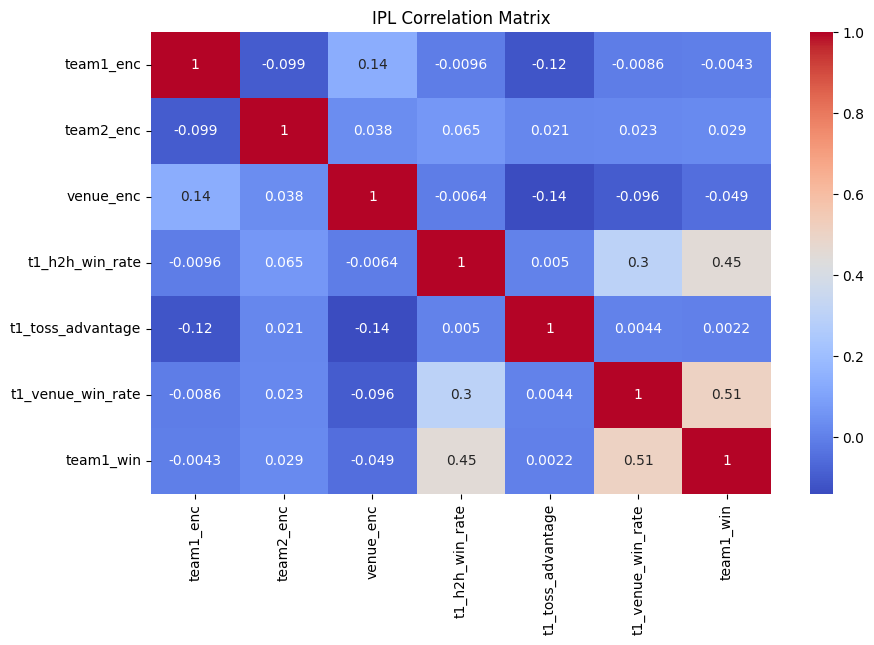

/Users/jayasuryareddy/Desktop/cap5771sp25-project/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.761468,0.764151,0.750000,0.757009
Random Forest,0.642202,0.636364,0.648148,0.642202
XGBoost,0.619266,0.619048,0.601852,0.610329


In [26]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(ipl_matches[features + ['team1_win']].corr(), annot=True, cmap='coolwarm')
plt.title("IPL Correlation Matrix")
plt.show()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds)
    }

    with open(f"{name.replace(' ', '_').lower()}_ipl.pkl", "wb") as f:
        pickle.dump(model, f)

# Show metrics
pd.DataFrame(results).T


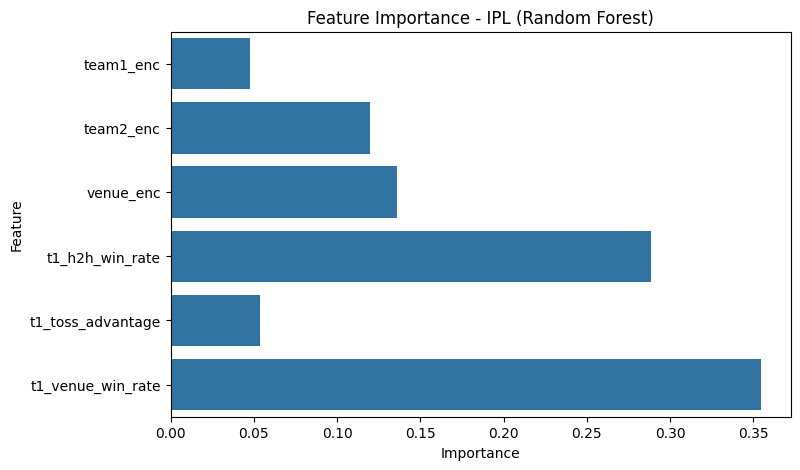

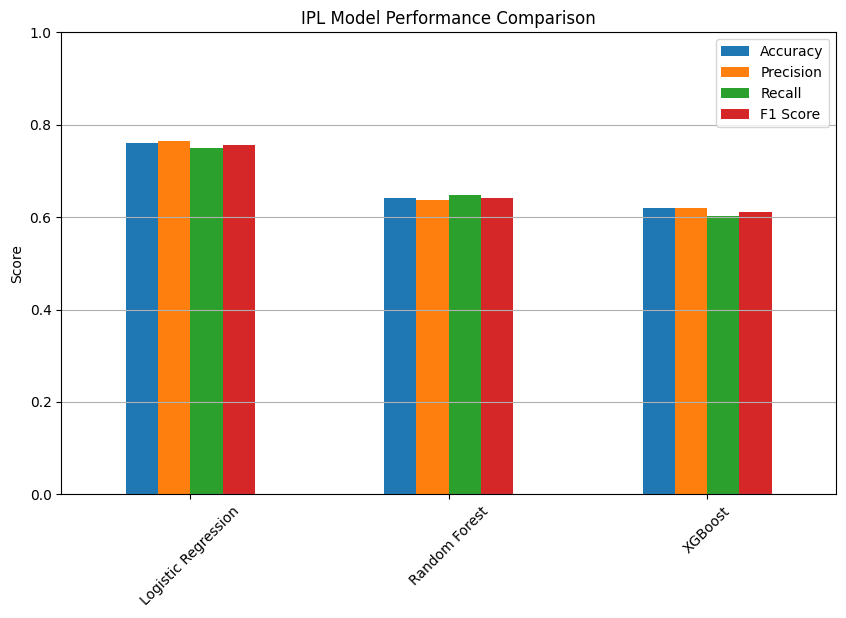

In [27]:
# Feature importance - Random Forest
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - IPL (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Model performance bar plot
results_df_ipl = pd.DataFrame(results).T
results_df_ipl[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10,6))
plt.title("IPL Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [31]:
# 📥 Load raw T20 match-level data
matches = pd.read_csv("T20/matches_it20.csv")
matches['date'] = pd.to_datetime(matches['date'])
matches = matches.sort_values('date').reset_index(drop=True)

# 📦 Generate rolling features for each match
rolling_features = []

for idx in range(10, len(matches)):  # start from 10 to ensure enough history
    if idx % 100 == 0:
        print(f"Processing match {idx}/{len(matches)}")

    current_match = matches.iloc[idx]
    past_matches = matches.iloc[:idx]

    t1 = current_match['team1']
    t2 = current_match['team2']
    venue = current_match['venue']

    # Head-to-head win rate
    h2h = past_matches[
        ((past_matches['team1'] == t1) & (past_matches['team2'] == t2)) |
        ((past_matches['team1'] == t2) & (past_matches['team2'] == t1))
    ]
    t1_h2h = (h2h['winner'] == t1).mean() if not h2h.empty else 0.5

    # Venue win rate
    venue_df = past_matches[(past_matches['venue'] == venue) & ((past_matches['team1'] == t1) | (past_matches['team2'] == t1))]
    venue_win_rate = (venue_df['winner'] == t1).mean() if not venue_df.empty else 0.5

    # Form: last 5 matches
    t1_recent = past_matches[(past_matches['team1'] == t1) | (past_matches['team2'] == t1)].tail(5)
    t1_form = (t1_recent['winner'] == t1).mean() if not t1_recent.empty else 0.5

    t2_recent = past_matches[(past_matches['team1'] == t2) | (past_matches['team2'] == t2)].tail(5)
    t2_form = (t2_recent['winner'] == t2).mean() if not t2_recent.empty else 0.5

    # Overall win rate (long-term strength)
    t1_matches = past_matches[(past_matches['team1'] == t1) | (past_matches['team2'] == t1)]
    t2_matches = past_matches[(past_matches['team1'] == t2) | (past_matches['team2'] == t2)]
    t1_win_rate = (t1_matches['winner'] == t1).mean() if not t1_matches.empty else 0.5
    t2_win_rate = (t2_matches['winner'] == t2).mean() if not t2_matches.empty else 0.5

    # Venue familiarity
    venue_familiarity_t1 = len(venue_df)

    # Result label
    winner = 1 if current_match['winner'] == t1 else 0

    rolling_features.append({
        'match_id': current_match['match_id'],
        't1_h2h_win_rate': t1_h2h,
        't1_venue_win_rate': venue_win_rate,
        't1_form': t1_form,
        't2_form': t2_form,
        't1_matches_played': len(t1_matches),
        't2_matches_played': len(t2_matches),
        't1_win_rate_overall': t1_win_rate,
        't2_win_rate_overall': t2_win_rate,
        'venue_familiarity_t1': venue_familiarity_t1,
        'winner': winner
    })

# 📤 Create and save the dataset
t20_rolling_df = pd.DataFrame(rolling_features)
t20_rolling_df.to_csv("T20/t20_rolling_features_v2.csv", index=False)

print("✅ Rolling feature dataset created:", t20_rolling_df.shape)


Processing match 100/1842
Processing match 200/1842
Processing match 300/1842
Processing match 400/1842
Processing match 500/1842
Processing match 600/1842
Processing match 700/1842
Processing match 800/1842
Processing match 900/1842
Processing match 1000/1842
Processing match 1100/1842
Processing match 1200/1842
Processing match 1300/1842
Processing match 1400/1842
Processing match 1500/1842
Processing match 1600/1842
Processing match 1700/1842
Processing match 1800/1842
✅ Rolling feature dataset created: (1832, 11)


In [32]:
# Load rolling feature dataset for T20 (v2 = with added features)
t20_df = pd.read_csv("T20/t20_rolling_features_v2.csv")

# Quick check
print("T20 Dataset Shape:", t20_df.shape)
t20_df.head()


T20 Dataset Shape: (1832, 11)


,match_id,t1_h2h_win_rate,t1_venue_win_rate,t1_form,t2_form,t1_matches_played,t2_matches_played,t1_win_rate_overall,t2_win_rate_overall,venue_familiarity_t1,winner
0,249227,0.0,0.5,0.5,0.333333,4,3,0.5,0.333333,0,1
1,258463,0.5,0.5,0.5,0.250000,0,4,0.5,0.250000,0,1
2,258464,1.0,1.0,1.0,0.200000,1,5,1.0,0.200000,1,0
3,306987,0.5,0.5,0.5,0.500000,0,0,0.5,0.500000,0,0
4,306989,0.5,0.5,1.0,1.000000,1,1,1.0,1.000000,0,1


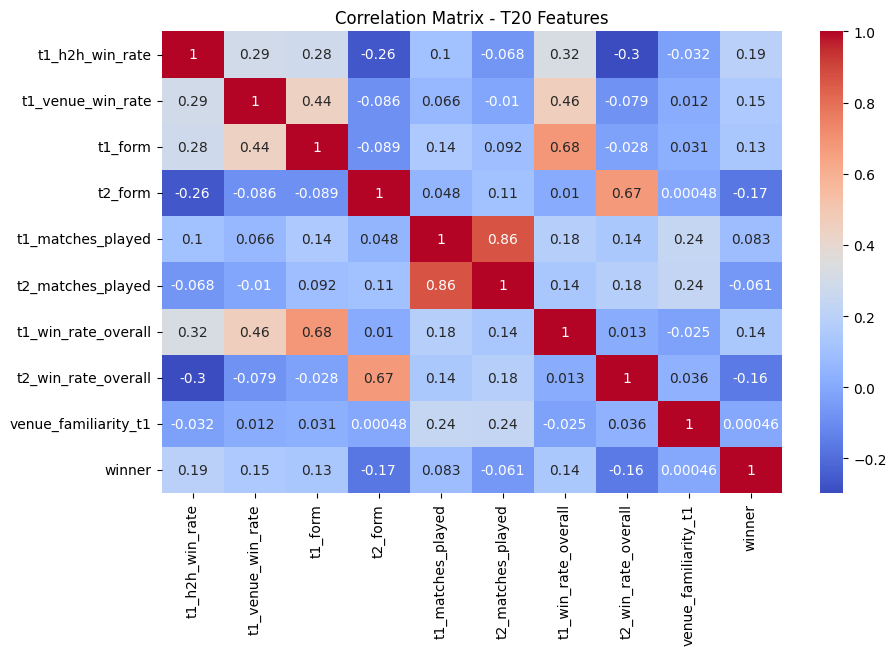

In [33]:
# Correlation heatmap of T20 features
plt.figure(figsize=(10,6))
sns.heatmap(t20_df.drop(columns=['match_id']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix - T20 Features")
plt.show()


In [ ]:
# Feature matrix and labels
X = t20_df.drop(columns=['match_id', 'winner'])
y = t20_df['winner']

# Time-aware train/test split (already sorted)
split_idx = int(0.8 * len(t20_df))
X_train_t20, X_test_t20 = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_t20, y_test_t20 = y.iloc[:split_idx], y.iloc[split_idx:]

# Define models
models_t20 = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results_t20 = {}

for name, model in models_t20.items():
    model.fit(X_train_t20, y_train_t20)
    preds = model.predict(X_test_t20)

    results_t20[name] = {
        "Accuracy": accuracy_score(y_test_t20, preds),
        "Precision": precision_score(y_test_t20, preds),
        "Recall": recall_score(y_test_t20, preds),
        "F1 Score": f1_score(y_test_t20, preds)
    }

    # Save model
    with open(f"{name.replace(' ', '_').lower()}_t20_v2.pkl", "wb") as f:
        pickle.dump(model, f)

# Show metrics
pd.DataFrame(results_t20).T

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.653951,0.594595,0.679012,0.634006
Random Forest,0.643052,0.597484,0.586420,0.591900
XGBoost,0.648501,0.595376,0.635802,0.614925


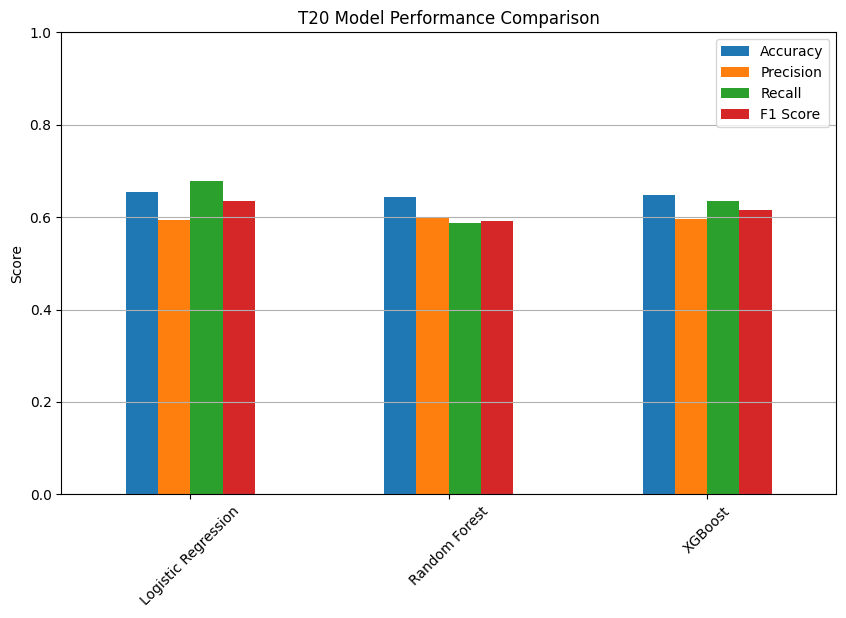

In [35]:
# Model performance comparison for T20
results_df_t20 = pd.DataFrame(results_t20).T
results_df_t20[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10,6))
plt.title("T20 Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
